In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
# For example, if the dataset has subdirectories for 'train' and 'test' sets:
train_dir = "./chest_xray/train"
test_dir = "./chest_xray/test"

In [3]:
# Example categories (labels)
categories = ['NORMAL', 'PNEUMONIA']

In [4]:
# Function to load images and labels
def load_images_from_directory(directory, categories):
    images = []
    labels = []
    for category in categories:
        category_dir = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img)
            try:
                img = load_img(img_path, target_size=(224, 224))  # Resize images to 224x224
                img = img_to_array(img)
                images.append(img)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load training and test data
train_images, train_labels = load_images_from_directory(train_dir, categories)
test_images, test_labels = load_images_from_directory(test_dir, categories)

print(f'Training data shape: {train_images.shape}')
print(f'Test data shape: {test_images.shape}')

Error loading image ./big/train/NORMAL/.DS_Store: cannot identify image file <_io.BytesIO object at 0x17c7fb380>
Error loading image ./big/train/PNEUMONIA/.DS_Store: cannot identify image file <_io.BytesIO object at 0x17c8ee7a0>
Training data shape: (5216, 224, 224, 3)
Test data shape: (624, 224, 224, 3)


In [5]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values from [0, 255] to [0, 1]
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly translate images horizontally
    height_shift_range=0.2,    # Randomly translate images vertically
    shear_range=0.2,           # Randomly shear images
    zoom_range=0.2,            # Randomly zoom in on images
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill in newly created pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

# Fit the data generator to the training data
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)


In [6]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print(f'Class weights: {class_weights_dict}')


Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [7]:
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)
np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)

In [8]:
# Load the pre-trained InceptionV3 model, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Fully connected layer with 256 units
predictions = Dense(2, activation='softmax')(x)  # Output layer for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [9]:
model.compile(optimizer=Adam(learning_rate=0.0006), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [10]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Fit the data generator to the training data
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)


In [11]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

callbacks = [checkpoint, early_stopping]


In [12]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks
)



Epoch 1/30


/Users/azadpatel/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 427ms/step - accuracy: 0.8193 - loss: 0.4387 - val_accuracy: 0.8349 - val_loss: 0.3677
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 417ms/step - accuracy: 0.8997 - loss: 0.2445 - val_accuracy: 0.8526 - val_loss: 0.3476
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 420ms/step - accuracy: 0.9120 - loss: 0.2121 - val_accuracy: 0.8429 - val_loss: 0.3556
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 416ms/step - accuracy: 0.9074 - loss: 0.2226 - val_accuracy: 0.7772 - val_loss: 0.4950
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 423ms/step - accuracy: 0.9141 - loss: 0.2153 - val_accuracy: 0.8237 - val_loss: 0.4242
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 426ms/step - accuracy: 0.9279 - loss: 0.1855 - val_accuracy: 0.8462 - val_loss: 0.3684
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 429ms/step - accuracy: 0.9252 - loss: 0.1806 - val_accuracy: 0.8542 - val_loss: 0.3439
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 428ms/step - accuracy: 0.9202 - loss: 0.1834 - val

In [22]:
# Save the model (optional)
model.save('my_model.keras')

In [41]:

loss_train, accuracy_train = model.evaluate(train_generator)
print(f'Train loss: {loss_train}')
print(f'Train accuracy: {accuracy_train}')

loss_test, accuracy_test = model.evaluate(test_generator)
print(f'Test loss: {loss_test}')
print(f'Test accuracy: {accuracy_test}')


163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 450ms/step - accuracy: 0.9287 - loss: 0.1772
Train loss: 0.1780519336462021
Train accuracy: 0.92695552110672
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - accuracy: 0.8822 - loss: 0.3035
Test loss: 0.2848252058029175
Test accuracy: 0.8910256624221802


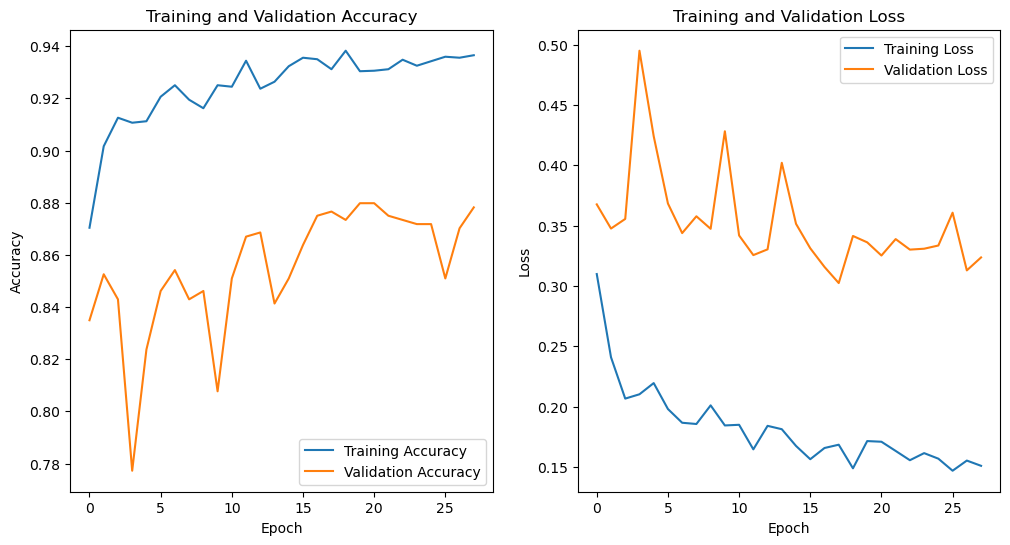

In [43]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()